In [1]:
import matplotlib.pyplot as plt
import numpy as np


def generate_linear_data(size, x0, xn, f=None, y_lo=0.5, y_hi=2):
    """Custom sample generation function. It's not good enough, but I'll keep it for now."""
    x = np.random.random(size) * (xn - x0) + x0
    if not f:
        f = lambda x: 3*x
    
    # g = (r o f)(x) -> multiplies the output of f(x) by a random noise
    g = lambda x: f(x)*(np.random.random() * (y_hi-y_lo) + y_lo)
#     g = lambda x: f(x)*(np.random.normal(1, 1) * (y_hi-y_lo) + y_lo)
    
    # returns a matrix [X Y]
    return np.stack((x, g(x)), axis=1)



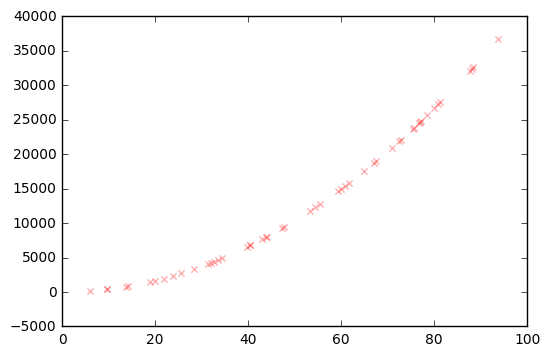

In [3]:
y = lambda x: 3*x**2-2*x+7
ds = generate_linear_data(50, 2, 100, f=y)

plt.scatter(ds[:,0],ds[:,1], marker='x', color='red', alpha=0.3)

plt.show()

# I didn't like this result so far, see the cell below.
# Still, I'm keeping it, as I might use it in the future...

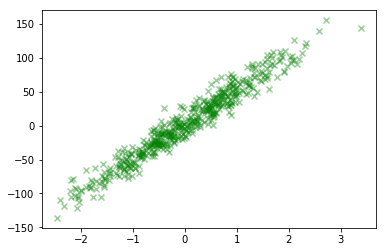

In [2]:
import sklearn.datasets as skd

# The noise coefficient is rather large, sometimes it'll generate a very fuzzy set of samples
ds = skd.make_regression(n_samples=500, n_features=1, n_informative=1, n_targets=1, bias=4, noise=12.5)
plt.scatter(ds[0], ds[1], marker='x', alpha=0.4, color='green')
plt.show()

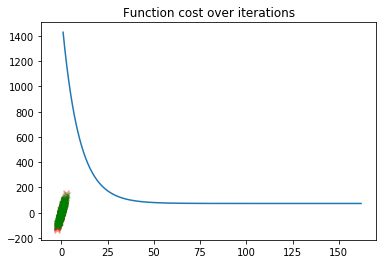

Train cost: 73.41149639008201


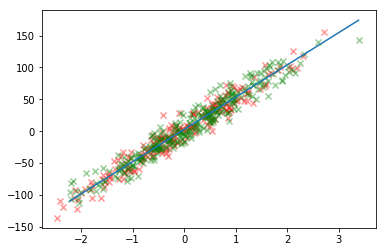

In [9]:
# Nice, we have a simple noisy-linear dataset. Let's build the regression model! :D
# linear hypothesis: h(X) = w_i * x_i ~ y_i

def gradient_descent(w, J, J_prime, alpha=0.1, epsilon=1e-5):
    old_cost = current_cost = 1e500
    m = float(w.shape[0])
    cost_history= list()
    
    while True:
        old_cost, current_cost = current_cost, J(w)
        cost_history.append(old_cost)
        
        if abs(old_cost - current_cost) < epsilon:
            break
        
        w -= alpha / m * J_prime(w)
        
    return w, cost_history


def mse_cost(X, Y, h, w, lmbda=0):
    """Vanilla MSE function."""
    
    squared_sum = lambda x: np.sum(np.square(x))
    
    m = float(X.shape[0])
    return 1/(2*m) * (squared_sum(h(X, w) - Y) + lmbda/(2*m) * squared_sum(w))


def mse_linear_prime(X, Y, h, w, lmbda=0):
    """MSE function derivative using experimental matrix multiplication shortcuts."""
    m = float(X.shape[0])
    
    scaled_error = 1/m * (h(X, w) - Y)
    lambda_part = lmbda/m * w
    lambda_part[0] = 0                        # bias is not regularized
        
    derivatives = (X.T).dot(scaled_error) + lambda_part

    return derivatives


def fit_linear(X, Y, lmbda=0):

    # m samples, n features
    m, n = X.shape
    
    # adding the 0-th column to X representing the bias
    bias_column = np.ones(m)[:, np.newaxis]
    X = np.concatenate((bias_column, X), axis=1)
        
    # initializing the weights with uniform distribution between [-1, 1)
    w = np.random.uniform(-1, 1, n+1)
    
    # the polynomial fit is also linear
    h = lambda x, w: x.dot(w)
    
    # parametrizing cost and error just by the weights
    mse_linear = lambda wp: mse_cost(X, Y, h, wp, lmbda)
    mse_cost_linear = lambda wp: mse_linear_prime(X, Y, h, wp, lmbda)
    
    # minimize cost function et voilá
    w_star, cost_history = gradient_descent(w, mse_linear, mse_cost_linear)
    
    return w_star, cost_history


def estimate(X, w):
    ones = np.ones((X.shape[0], 1))
    X = np.concatenate((ones, X), axis=1)
    return X.dot(w)


fraction = int(0.4 * len(ds[0]))
X_train = ds[0][:fraction]
Y_train = ds[1][:fraction]

X_test = ds[0][fraction:]
Y_test = ds[1][fraction:]

w_star, cost_history = fit_linear(X_train, Y_train)

plt.plot(range(len(cost_history)), cost_history)
plt.title('Function cost over iterations')
plt.show()

print("Train cost: {}".format(cost_history[-1]))

# Not considering validation set here
plt.scatter(X_train, Y_train, marker='x', alpha=0.4, color='red')
plt.scatter(X_test, Y_test, marker='x', alpha=0.4, color='green')

X_test = np.array(sorted(X_test))
plt.plot(X_test, estimate(X_test, w_star))
plt.show()